In [ ]:
import os

import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from jax import random

from diffdeb.config import get_config_LDM
from diffdeb.dataset import batched_CATSIMDataset
from diffdeb.diffusion import forward_noising
from diffdeb.load_weights import load_model_weights
from diffdeb.train_LDM import noisy_latent_images

# Linear Schedule 

In [ ]:
beta_linear = jnp.linspace(0.0001, 0.05, 500)
alpha_linear = 1 - beta_linear
alpha_bar_linear = jnp.cumprod(alpha_linear, 0)
alpha_bar_linear = jnp.concatenate((jnp.array([1.0]), alpha_bar_linear[:-1]), axis=0)
sqrt_alpha_bar_linear = jnp.sqrt(alpha_bar_linear)
one_minus_sqrt_alpha_bar_linear = jnp.sqrt(1 - alpha_bar_linear)

In [ ]:
def compute_betas(timesteps, s=0.008):
    def f(t):
        return jnp.cos((t / timesteps + s) / (1 + s) * 0.5 * jnp.pi) ** 2

    x = jnp.linspace(0, timesteps, timesteps + 1)
    alpha_bar = f(x) / f(jnp.asarray([0]))
    betas = 1 - alpha_bar[1:] / alpha_bar[:-1]
    return jnp.clip(betas, 0.00001, 0.05)

In [ ]:
beta = compute_betas(timesteps=500)
alpha = 1 - beta
alpha_bar = jnp.cumprod(alpha, 0)
alpha_bar = jnp.concatenate((jnp.array([1.0]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = jnp.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = jnp.sqrt(1 - alpha_bar)

In [ ]:
sns.set_theme(
    font_scale=1.5,
    style={
        "style": "whitegrid",
        "xtick.bottom": True,
        "axes.grid": True,
        "xtick.top": False,
        "ytick.left": True,
        "ytick.right": False,
        "text.color": ".1",
        "xtick.color": ".1",
        "ytick.color": ".1",
        "axes.edgecolor": ".85",
        "axes.labelcolor": ".1",
    },
    rc={"grid.color": ".85", "grid.linestyle": "--"},
)

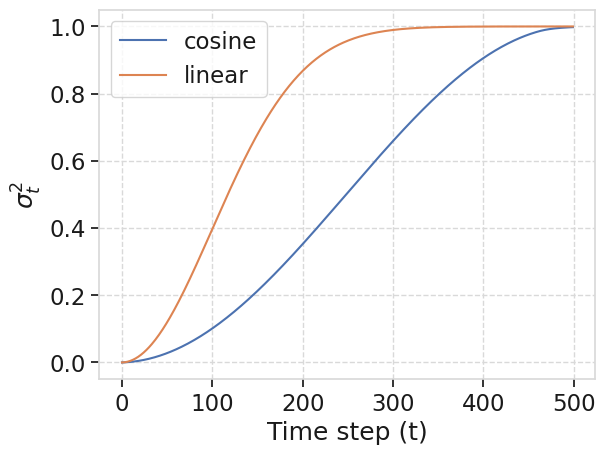

In [ ]:
plt.plot(jnp.arange(0, 500), 1 - alpha_bar, label="cosine")
plt.plot(jnp.arange(0, 500), 1 - alpha_bar_linear, label="linear")
plt.xlabel("Time step (t)")
plt.ylabel(r"$\sigma^2_t$")
plt.legend()

plt.savefig(
    os.path.join("results", "noise_var.pdf"),
    format="pdf",
    bbox_inches="tight",
)

# Load Data

In [ ]:
rng = random.key(42)
config = get_config_LDM()

In [ ]:
ds_isolated_train, ds_isolated_val = batched_CATSIMDataset(
    tf_dataset_dir=os.path.join(
        "/sps/lsst/users/bbiswas/simulations/LSST/",
        "isolated_tfDataset",
    ),
    linear_norm_coeff=config.diffusion_config.linear_norm_coeff,
    batch_size=config.diffusion_config.batch_size,
    x_col_name="blended_gal_stamps",
    y_col_name="isolated_gal_stamps",
)

ds_isolated_train = ds_isolated_train.as_numpy_iterator()
ds_isolated_val = ds_isolated_val.as_numpy_iterator()

# Add Noise In Image Space

In [ ]:
rng, key = random.split(rng)
batch = next(ds_isolated_val)
# timestamps = random.randint(
#     key,
#     shape=(batch[0].shape[0],),
#     minval=0,
#     maxval=config.diffusion_config.timesteps,
# ) # Randomly choose time stamp


timestamps = jnp.array([79] * batch[1].shape[0])  # choose a fixed time stamp

# Generating the noise and noisy image for this batch
rng, key = random.split(rng)
noisy_images, noise = forward_noising(key, batch[1], timestamps)

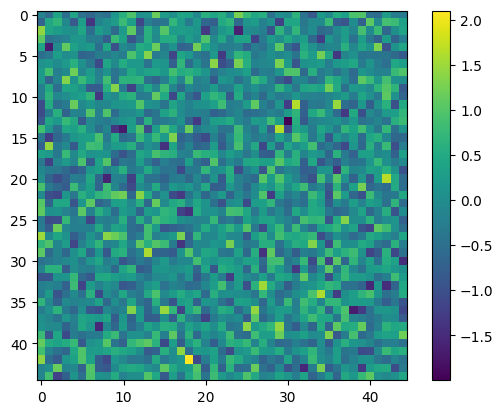

In [ ]:
plt.imshow(noisy_images[0, :, :, 2] - batch[1][0, :, :, 2])
plt.colorbar()

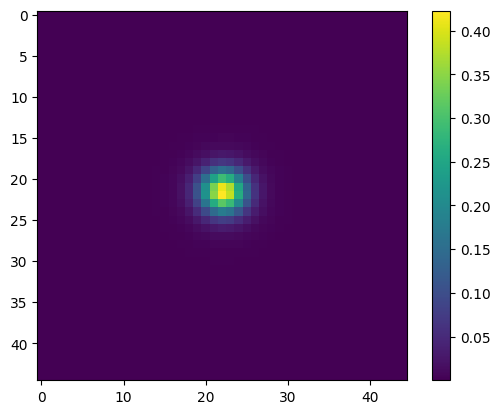

In [ ]:
plt.imshow(batch[1][0, :, :, 2])
plt.colorbar()

# Add Noise In Latent Space

In [ ]:
encoder_params = load_model_weights(config.vae_config)["encoder"]
decoder_params = load_model_weights(config.vae_config)["decoder"]
vae_params = load_model_weights(config.vae_config)

UNet_pararms = load_model_weights(config.diffusion_config)

Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae and step 17
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae and step 17
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae and step 17
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/UNet
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/UNet and step 65


In [ ]:
noisy_images, latent_batch, noise, timestamps = noisy_latent_images(
    rng=key,
    batch_size=config.diffusion_config.batch_size,
    t_min_val=0,
    t_max_val=200,  # Maximum numer of time steps, T is unformly sampled from 0 to timesteps-1
    batch=batch[0],
    encoder_params=encoder_params,
    latent_dim=config.vae_config.latent_dim,
    encoder_filters=config.vae_config.encoder_filters,
    encoder_kernels=config.vae_config.encoder_kernels,
    dense_layer_units=config.vae_config.dense_layer_units,
    exp_constant=config.exp_constant,
    latent_scaling_factor=config.latent_scaling_factor,
)

In [ ]:
im_to_display = 1

Text(0.5, 1.0, 'Actual latnet image (channel 0)')

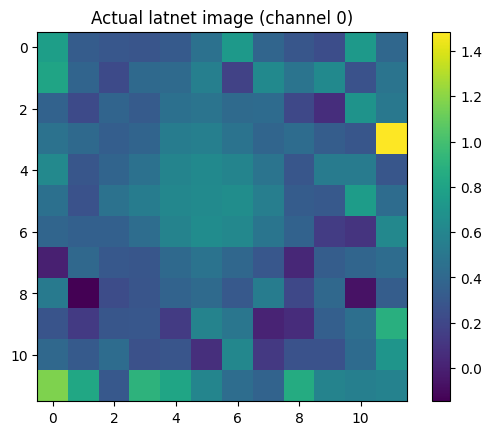

Text(0.5, 1.0, 'Noisy added after 185 steps')

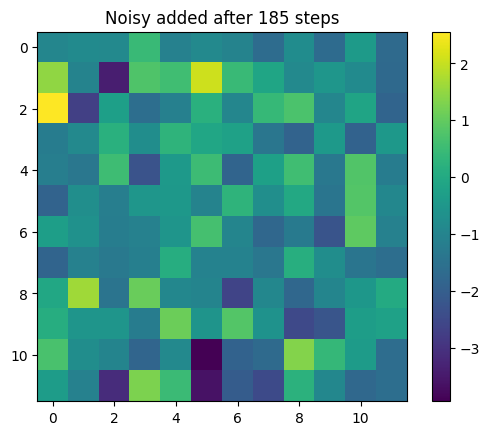

In [ ]:
plt.imshow(noisy_images[im_to_display, :, :, 2] - latent_batch[im_to_display, :, :, 2])
plt.colorbar()
print()
plt.title(f"Noisy added after {timestamps[im_to_display]} steps")

Text(0.5, 1.0, 'Noisy image after 185 steps')

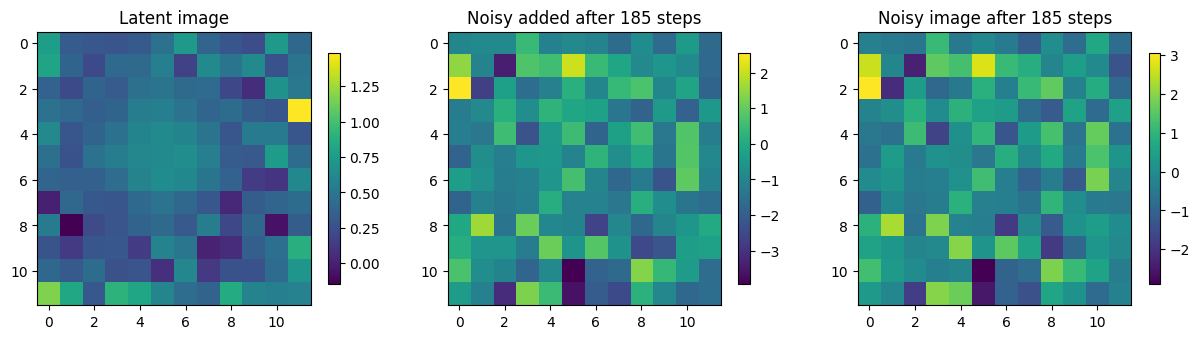

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

im = axs[0].imshow(latent_batch[im_to_display, :, :, 0])
fig.colorbar(im, shrink=0.5)
axs[0].set_title("Latent image")

im = axs[1].imshow(
    noisy_images[im_to_display, :, :, 2] - latent_batch[im_to_display, :, :, 2]
)
fig.colorbar(im, shrink=0.5)
axs[1].set_title(f"Noisy added after {timestamps[im_to_display]} steps")

im = axs[2].imshow(noisy_images[im_to_display, :, :, 2])
fig.colorbar(im, shrink=0.5)
axs[2].set_title(f"Noisy image after {timestamps[im_to_display]} steps")